<a href="https://colab.research.google.com/github/sirius59/ART_AI/blob/sirius59-patch/ART_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Binôme T: De Carvalho Mickael et Laisney Clément

algorithme qui prédit le style de l'oeuvre d'art (impressionnisme, pop art, cubisme etc...) et peut être je dit bien PEUT ETRE 
arriver à un algorithme qui créer une oeuvre en fonction du style demandé.

jeu de données:
https://www.kaggle.com/ikarus777/best-artworks-of-all-time

points de départ: 

- réseau de convolution
- réduction de dimension pour classer 

retrouvez notre travail sur https://github.com/sirius59/ART_AI

### Import libraries

In [1]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

### Download the dataset from internet and extract it on the system

**We resized all images to 562x562 with a preview script available in the github page:** https://github.com/sirius59/ART_AI/blob/main/traitement%20des%20images.py

NB: replace the link by a new one using this URL in case of an issue like "file is not a zipfile" https://www.mediafire.com/file/v5jpwfjeldhmc8z/dataset_resized.zip/file

In [60]:
zipurl = 'https://download1483.mediafire.com/azvmtxdfqs1g/v5jpwfjeldhmc8z/dataset_resized.zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()

# Core of the script

## Extracting metadata from artist.csv and labelize genres

In [2]:
artists=pd.read_csv('/content/dataset_resized/artists.csv')

##name of artists
artists['name'][19]='Albrecht_Durer' #fix ASCII problems
tmp=artists['name']
name=[tmp[i].replace(' ','_') for i in range(len(tmp))]#replace space by underscore, more convinent to import images

##genre of artists
tmp=artists['genre']
genre=[tmp[i].replace(',','/') for i in range(len(tmp))]#replace coma by slash, avoid mistakes in list

##number of paintings by artists
nb_paints=artists['paintings']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Labelize a genre with a number

In [3]:
#genre_label={'Expressionism':1,'Abstractionism':2,'Social Realism':3,'Muralism':4,'Impressionism':5,'Surrealism':6,'Byzantine Art':7,'Post-Impressionism':8,'Symbolism':9,'Art Nouveau':10,'Northern Renaissance':11,'Suprematism':12,'Cubism':13,'Baroque':14,'Romanticism':15,'Primitivism':16,'Mannerism':17,'Proto Renaissance':18,'Early Renaissance':19,'High Renaissance':20,'Neoplasticism':21,'Pop Art':22,'Abstract Expressionism':23}
#labelize a genre by a number

In [4]:
genre_label={'Impressionism':0,'Baroque':1}

Function to find the key associated with the label

In [5]:
def find_key(v): 
    for k, val in genre_label.items(): 
        if v == val: 
            return k 
    return "Key does not exist"

## Append all artworks in a list (for later)

In [6]:
#artworks=[]#list of [img,artist,genre]
#for i in range(len(name)):
#  for j in range(nb_paints[i]):
#    data=[plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'),name[i],genre[i]] #[img,artist,genre]
#    artworks.append(data)

## Append artworks of 2 differents styles in a list
We choose 2 differents styles well represented in the dataset en choose 4 artists of each genre in order to have about 50/50 in term of artworks

In [12]:
input_shape=plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg').shape
artworks=[]
artworks_genre=[]
genre1=(3,14,15,20,25,27,31) #~50/50 impressionism/Baroque (maybe include less images to save RAM)
for i in genre1:
  for j in range(nb_paints[i]):
    if i==20 and j==198:#shape problem for this image
      continue
    artworks.append(plt.imread(f'/content/dataset_resized/resized/{name[i]}_{j+1}.jpg'))
    artworks_genre.append(genre[i])
artworks=np.array(artworks) #images
artworks_genre=np.array(artworks_genre) #string of the genre
artworks_label=np.array([genre_label[artworks_genre[i]] for i in range(len(artworks_genre))]) #integer corresponding to the genre

We choose to represent 2 differents artworks of each genre in order to visualize datas

Text(0.5, 1.0, 'Baroque')

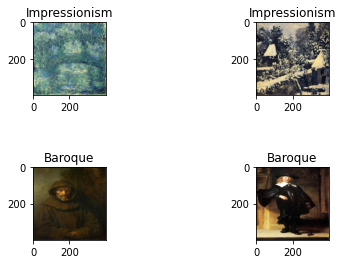

In [13]:
plt.figure()
plt.subplots_adjust(wspace=1, hspace=1)
plt.subplot(221)
plt.imshow(artworks[0])
plt.title(f'{artworks_genre[0]}')
plt.subplot(222)
plt.imshow(artworks[300])
plt.title(f'{artworks_genre[300]}')
plt.subplot(223)
plt.imshow(artworks[-1])
plt.title(f'{artworks_genre[-1]}')
plt.subplot(224)
plt.imshow(artworks[-200])
plt.title(f'{artworks_genre[-200]}')

In [14]:
prepared_label=to_categorical(artworks_label) #vectorize the label

## Shuffle and split of the dataset

In [15]:
x_train,x_test,y_train,y_test=train_test_split(artworks,artworks_label, test_size=0.33, random_state=42, shuffle=True)

## CNN

In [20]:
model=Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.33))
model.add(Dense(1, activation='softmax'))

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 398, 398, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 199, 199, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 197, 197, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 64)       

In [23]:
model.fit(x_train,y_train, batch_size=64, epochs=2)

Epoch 1/2
14/14 [==============================] - 42s 424ms/step - loss: 0.0000e+00 - accuracy: 0.4799
Epoch 2/2
14/14 [==============================] - 5s 342ms/step - loss: 0.0000e+00 - accuracy: 0.4669
